### Criando sistema de patching do Tolstaya
- passo a passo do método

#### Imports

In [9]:
import os
import gc
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader

#### Datasets

In [10]:
# f
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

#### graficos

In [11]:
def plot_image_channels(image, title="Image Channels"):
    channels = image.shape[-1]  # Número de canais
    fig, axs = plt.subplots(1, channels, figsize=(15, 5))
    
    for i in range(channels):
        axs[i].imshow(image[:, :, i], cmap="gray")
        axs[i].set_title(f"Channel {i + 1}")
        axs[i].axis("off")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_image_labels(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title("Label")
    plt.axis("off")  # Remove os eixos, se desejado
    plt.show()

#### Preparando dados

In [12]:
train_path = Path(train_path)
annotations_path = Path(annotation_path)

In [13]:
train_img_reader = TiffReader(train_path / "train")
train_label_reader = PNGReader(annotations_path / "train")

- verificando tamanho dos arrays
- verificando se os shapes sao diferentes
    - inline e crossline tem shapes diferentes

In [14]:
print("len: ", len(train_img_reader), len(train_label_reader))

shapes_img = {img.shape for img in train_img_reader}
if len(shapes_img) > 1:
    print("tem imgs com shapes diferentes: ", shapes_img)
else:
    print("shapes iguais")
del shapes_img

shapes_label = {img.shape for img in train_label_reader}
if len(shapes_label) > 1:
    print("tem imgs com shapes diferentes: ", shapes_label)
else:
    print("shapes iguais")
del shapes_label
gc.collect()

len:  992 992
tem imgs com shapes diferentes:  {(255, 701, 3), (255, 401, 3)}


KeyboardInterrupt: 

1) garantir que as imagens estejam normalizadas
    - segundo tolstaya, as imagens devem estar no intervalo (-1,1)

In [ ]:
# Função para normalizar o intervalo de dados
def normalize_data(data, target_min=-1, target_max=1):
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

normalized_images = [normalize_data(image) for image in train_img_reader]

In [ ]:
print("min e max antes: ", np.min(train_img_reader[0]), np.max(train_img_reader[0]))
print("min e max depois: ", np.min(normalized_images[0]), np.max(normalized_images[0]))

min e max antes:  -1.0 1.0
min e max depois:  -1.0 1.0


- experimento adicional 1:
    - adicionar um canal de probabilidades de facies

In [ ]:
def generate_facies_probability_channel(patch, facies_probabilities):
    prob_map = np.random.choice(
        len(facies_probabilities), size=patch.shape, p=facies_probabilities
        )
    return prob_map

(255, 701)
(255, 701)


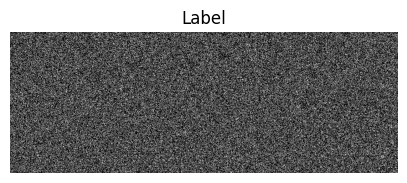

In [ ]:
sample_image = normalized_images[0][:, :, 0]
facies_probabilities = np.array([0.2857, 0.1207, 0.4696, 0.0747, 0.0361, 0.0132])
print(sample_image.shape)
prob_channel = generate_facies_probability_channel(sample_image, facies_probabilities)
print(prob_channel.shape)
# plot_image_channels(prob_channel, title="Visualization of All Channels")
plot_image_labels(prob_channel)
del facies_probabilities, sample_image, prob_channel

- experimento adicional 2:
    - Atributos Sísmicos Derivados
        - amplitude

(255, 701)


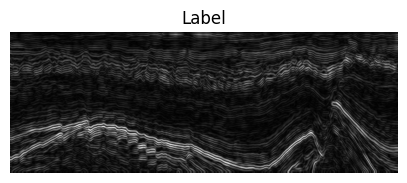

(255, 701)


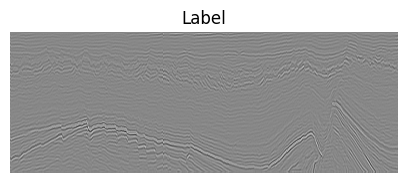

(255, 701)


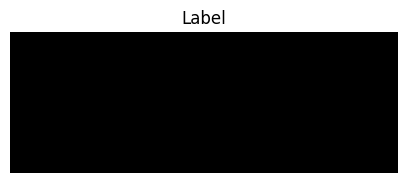

(255, 701)


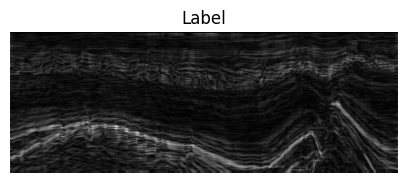

(255, 701)


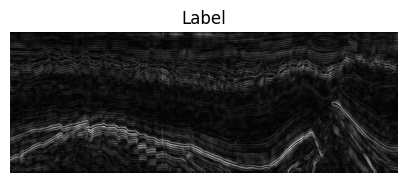

(255, 701)


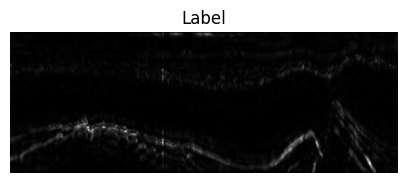

In [ ]:
from scipy.ndimage import gaussian_gradient_magnitude, laplace
import numpy as np
from scipy.signal import hilbert
from scipy.ndimage import uniform_filter

def generate_amplitude_gradient_channel(patch):
    # Usa gradiente de amplitude com suavização
    gradient_channel = gaussian_gradient_magnitude(patch, sigma=1)
    return gradient_channel / np.max(gradient_channel)  # Normalização

sample_image = normalized_images[0][:, :, 0]
amplitude_channel = generate_amplitude_gradient_channel(sample_image)
print(amplitude_channel.shape)
plot_image_labels(amplitude_channel)
del amplitude_channel

def generate_curvature_channel(patch):
    # Calcula a curvatura usando o filtro de Laplace
    curvature_channel = laplace(patch)
    return curvature_channel / np.max(np.abs(curvature_channel))  # Normaliza para [-1, 1]

curvature_channel = generate_curvature_channel(sample_image)
print(curvature_channel.shape)
plot_image_labels(curvature_channel)
del curvature_channel

def generate_dominant_frequency_channel(patch):
    # Calcula a transformada de Fourier 2D
    fft_patch = np.fft.fft2(patch)
    fft_shifted = np.fft.fftshift(fft_patch)  # Centraliza as frequências
    magnitude = np.abs(fft_shifted)
    
    # Calcula a frequência dominante (pico de magnitude)
    dominant_frequency = np.unravel_index(np.argmax(magnitude), magnitude.shape)
    
    # Vamos gerar uma "mapa" de frequência dominante no patch
    freq_channel = np.full(patch.shape, magnitude[dominant_frequency] / np.max(magnitude))
    return freq_channel

dominant_frequency_channel = generate_dominant_frequency_channel(sample_image)

print(dominant_frequency_channel.shape)
plot_image_labels(dominant_frequency_channel)
del dominant_frequency_channel

def generate_amplitude_envelope_channel(patch):
    # Aplica a transformada de Hilbert para obter a envolvente
    analytic_signal = hilbert(patch)
    envelope = np.abs(analytic_signal)
    return envelope / np.max(envelope)  # Normaliza

envelope_channel = generate_amplitude_envelope_channel(sample_image)

print(envelope_channel.shape)
plot_image_labels(envelope_channel)
del envelope_channel

def generate_stress_channel(patch):
    # Calcula o gradiente na direção horizontal e vertical
    grad_x = np.gradient(patch, axis=0)
    grad_y = np.gradient(patch, axis=1)
    
    # A tensão é a soma dos gradientes nas duas direções
    stress = np.sqrt(grad_x**2 + grad_y**2)
    return stress / np.max(stress)  # Normaliza

stress_channel = generate_stress_channel(sample_image)

print(stress_channel.shape)
plot_image_labels(stress_channel)
del stress_channel

def generate_noise_activity_channel(patch, window_size=3):
    # Calcula a variância local usando uma janela deslizante
    local_mean = uniform_filter(patch, size=window_size)
    local_variance = uniform_filter((patch - local_mean)**2, size=window_size)
    
    # Normaliza a variância local para o intervalo [0, 1]
    return local_variance / np.max(local_variance)

noise_activity_channel = generate_noise_activity_channel(sample_image)

print(noise_activity_channel.shape)
plot_image_labels(noise_activity_channel)
del sample_image, noise_activity_channel

- experimento adicional 3:
    - Histograma Local de Fácies (ou Amplitudes)

(255, 700)


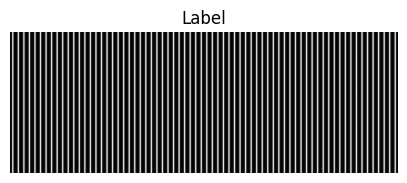

In [ ]:
def generate_histogram_channel(patch, num_bins=10):
    hist, _ = np.histogram(patch, bins=num_bins, range=(-1, 1), density=True)
    hist_channel = np.tile(hist, (patch.shape[0], patch.shape[1] // num_bins))
    return hist_channel[:patch.shape[0], :patch.shape[1]]

sample_image = normalized_images[0][:, :, 0]
hist_channel = generate_histogram_channel(sample_image)
print(hist_channel.shape)
plot_image_labels(hist_channel)
del sample_image, hist_channel

2) gerar canal de profundidade
    - segundo tolstaya, cada imagem deve ter um canal de profundidade, indo de 0 no topo até 1 na base

In [ ]:
def generate_depth_channel(shape):
    depth_channel = np.linspace(1, 0, shape[0]).reshape(-1, 1)
    return np.tile(depth_channel, (1, shape[1]))

In [ ]:
# Função corrigida para lidar com diferentes shapes
two_channel_images = []

for img in normalized_images:  # Garantir que está trabalhando com imagens normalizadas
    depth_channel = generate_depth_channel(img.shape[:2])  # Gerar canal de profundidade para esta imagem
    
    if img.shape[-1] > 1:  # Se a imagem tiver múltiplos canais
        # Escolher apenas o primeiro canal (exemplo, pode ser qualquer canal)
        img = img[:, :, 0:1]  # Seleciona o primeiro canal e mantém as dimensões (H, W, 1)
    
    # gerando canal 3 (teste)
    canal_3 = generate_amplitude_gradient_channel(img)

    # Concatenar o primeiro canal com o depth_channel
    depth_channel = np.expand_dims(depth_channel, axis=-1)  # Tornar (H, W, 1)
    two_channel_image = np.concatenate((img, depth_channel, canal_3), axis=-1)  # Concatenar ao longo do eixo dos canais
    two_channel_images.append(two_channel_image)  # Adicionar ao array final

shapes_img = {img.shape for img in two_channel_images}
if len(shapes_img) > 1:
    print("tem imgs com shapes diferentes: ", shapes_img)
else:
    print("shapes iguais")
del shapes_img, normalized_images
gc.collect()

print("len: ", len(two_channel_images))

tem imgs com shapes diferentes:  {(255, 701, 3), (255, 401, 3)}
len:  992


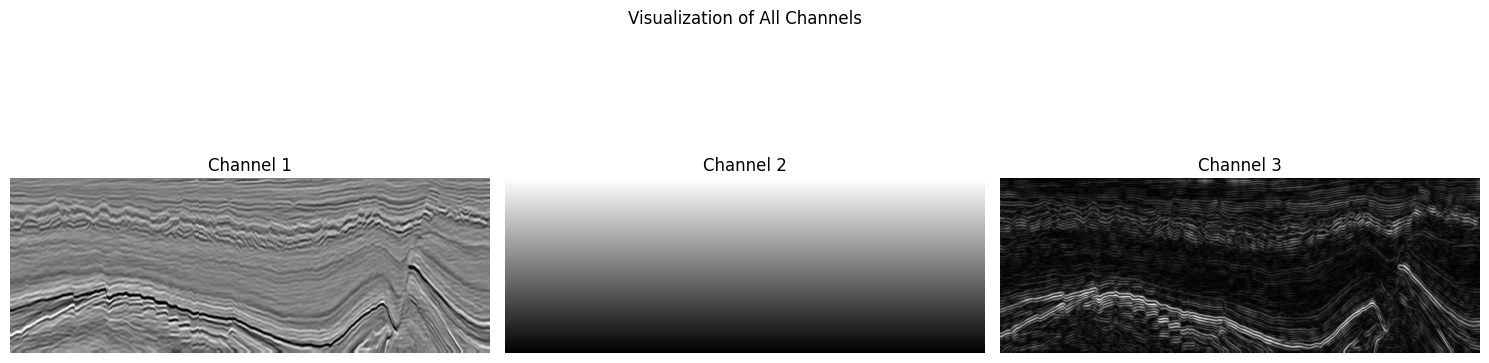

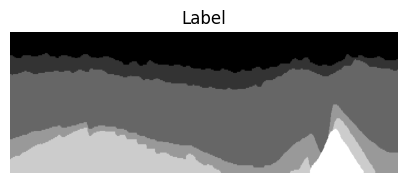

In [ ]:
# Seleciona uma imagem para visualização (exemplo: primeira imagem)
sample_image = two_channel_images[0]
sample_label = train_label_reader[0]

# Plota os canais da imagem selecionada
plot_image_channels(sample_image, title="Visualization of All Channels")
plot_image_labels(sample_label)

In [ ]:
del train_img_reader
gc.collect()

7728

3) divisão em patches
    - dividir os dados em patches fixos (256,256) ou (384,384), para treinamento e inferencia
    - usar sliding windows com sobreposicao

In [ ]:
def extract_patches(data, patch_size, stride):
    patches = []
    h, w, _ = data.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = data[i:i + patch_size, j:j + patch_size]
            patches.append(patch.transpose(2, 1, 0))

    return patches

In [ ]:
# Configurar parâmetros de extração
patch_size = 255
stride = 32
batch_size = 8

In [ ]:
# Gerar patches com sobreposição para todas as imagens
patches_generator = []
for image in two_channel_images:
    patches_generator.extend(extract_patches(image, patch_size, stride))

print("Total patches: ", len(patches_generator))

# Para acessar os patches gerados
for i, patch in enumerate(patches_generator):
    if i == 0:  # Apenas para mostrar o shape do primeiro patch
        print(f"Shape of a single patch: {patch.shape}")

del patches_generator
gc.collect()

Total patches:  8209
Shape of a single patch: (3, 255, 255)


497

### Montando classe PatchingTolstayaModule
- essa classe implementa todo o método em uma herança de L.LightningDataModule

In [1]:
import os
import random
import gc
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_gradient_magnitude, laplace

import pytorch_lightning as L
from torch.utils.data import DataLoader
import torch

from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.transforms.transform import Flip

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:
class PatchingTolstayaModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data, target_min=-1, target_max=1):
        """
        Função responsável por normalizar as imagens no intervalo (-1,1)
        """
        data_min, data_max = data.min(), data.max()
        return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

    # função útil
    def generate_depth_channel(self, shape):
        """
        Função responsável por criar o canal de profundidade, com 0 no topo e 1 na base.
        """
        depth_channel = np.linspace(0, 1, shape[0]).reshape(-1, 1)
        return np.tile(depth_channel, (1, shape[1]))
    
    # função útil
    def extract_patches(self, data, patch_size=255, stride=32, img_type='image'):
        patches = []
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                patch = data[i:i + patch_size, j:j + patch_size]
                if img_type == 'image':
                    patches.append(patch.transpose(2, 0, 1).astype(np.float32)) # o SAM só recebe (C H W)
                else:
                    patches.append(patch.astype(np.int64))
        return np.array(patches)
    
    # funcao utils
    def generate_facies_probability_channel(self, patch, facies_probabilities):
        prob_map = np.random.choice(
            len(facies_probabilities), size=patch.shape, p=facies_probabilities
            )
        return prob_map

    # funcao util
    def generate_amplitude_gradient_channel(self, patch):
        # Usa gradiente de amplitude com suavização
        gradient_channel = gaussian_gradient_magnitude(patch, sigma=1)
        return gradient_channel / np.max(gradient_channel)  # Normalização

    # funcao util
    def generate_curvature_channel(self, patch):
        # Calcula a curvatura usando o filtro de Laplace
        curvature_channel = laplace(patch)
        return curvature_channel / np.max(np.abs(curvature_channel))  # Normaliza para [-1, 1]

    # função útil
    def generate_image_with_depth(self, normalized_images):
        two_channel_images = []
        for img in normalized_images:  # Garantir que está trabalhando com imagens normalizadas
            depth_channel = self.generate_depth_channel(img.shape[:2])  # Gerar canal de profundidade para esta imagem

            if img.shape[-1] > 1:  # Se a imagem tiver múltiplos canais
                # Escolher apenas o primeiro canal (exemplo, pode ser qualquer canal)
                img = img[:, :, 0:1]  # Seleciona o primeiro canal e mantém as dimensões (H, W, 1)
            
            # gerando canal 3 (teste)
            # facies_probabilities = np.array([0.2857, 0.1207, 0.4696, 0.0747, 0.0361, 0.0132])
            # canal_3 = self.generate_facies_probability_channel(img, facies_probabilities)
            # canal_3 = self.generate_amplitude_gradient_channel(img)
            # canal_3 = self.generate_curvature_channel(img)

            # Concatenar o primeiro canal com o depth_channel
            depth_channel = np.expand_dims(depth_channel, axis=-1)  # Tornar (H, W, 1)
            two_channel_image = np.concatenate((img, depth_channel), axis=-1)  # Concatenar ao longo do eixo dos canais
            two_channel_images.append(two_channel_image)  # Adicionar ao array final
        return two_channel_images
    
    # função util
    def horizontal_flip(self, image, label):
        if not isinstance(image, np.ndarray):
            raise ValueError(f"Experado image com type <class 'numpy.ndarray'>, mas foi recebido {type(image)}")
        if not isinstance(label, np.ndarray):
            raise ValueError(f"Experado label com type <class 'numpy.ndarray'>, mas foi recebido {type(label)}")

        if image.shape[0] != 3 or image.shape[1] != self.patch_size or image.shape[2] != self.patch_size:
            raise ValueError(f"Experado image com shape (C=3 H=patch_size W=patch_size), mas foi recebido {image.shape}")
        if label.shape[0] != self.patch_size or label.shape[1] != self.patch_size:
            raise ValueError(f"Experado label com shape (H=patch_size W=patch_size), mas foi recebido {label.shape}")

        image_flipped = np.flip(image, axis=2)
        label_flipped = np.flip(label, axis=1)

        # if any(s < 0 for s in image_flipped.strides):
        #     print(f"array com strides negativos detectado")

        return image_flipped.copy(), label_flipped.copy()
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Gerar imagens com canais de profundidade
            # train_img_reader = self.generate_image_with_depth(train_img_reader)
            
            # Gerar patches em batches
            patches_img_generator = []
            for image in train_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in train_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            # """ augmentation """
            # # Aplicar augmentações nas imagens e labels, somente para as amostras com 3, 4 ou 6 classes
            # augmented_img_generator = []
            # augmented_label_generator = []
            # for img, label in zip(patches_img_generator, patches_label_generator):
            #     # TODO tá estourando nessa parte
            #     augmented_img_generator.append(img)
            #     augmented_label_generator.append(label)
            #     # Verificar o número de classes na amostra
            #     unique_classes = np.unique(label)
            #     num_classes = len(unique_classes)
                
            #     if num_classes in [3, 4, 6]:  # Apenas aplicar augmentação nas amostras com 3, 4 ou 6 classes
            #         img_horizontal_flip, label_horizontal_flip = self.horizontal_flip(img, label)
            #         augmented_img_generator.append(img_horizontal_flip)
            #         augmented_label_generator.append(label_horizontal_flip)
            
            # Criar dataset para treinamento
            self.datasets["train"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del train_img_reader, train_label_reader
            del patches_img_generator, patches_label_generator
            # del augmented_img_generator, augmented_label_generator
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            # gerar imagens com canais de profundidade
            # val_img_reader = self.generate_image_with_depth(val_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in val_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in val_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            self.datasets["val"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del val_img_reader, val_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            # gerar imagens com canais de profundidade
            # test_img_reader = self.generate_image_with_depth(test_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in test_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in test_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            test_dataset = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del test_img_reader, test_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

#### testando

In [3]:
def plot_image_channels(image, title="Image Channels"):
    channels = image.shape[0]  # Número de canais (considerando formato (c, h, w))
    fig, axs = plt.subplots(1, channels, figsize=(15, 5))
    
    for i in range(channels):
        axs[i].imshow(image[i, :, :], cmap="gray")
        axs[i].set_title(f"Channel {i + 1}")
        axs[i].axis("off")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_image_labels(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title("Label")
    plt.axis("off")  # Remove os eixos, se desejado
    plt.show()

In [4]:
# f
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [5]:
data_module = PatchingTolstayaModule(
    train_path=train_path,
    annotations_path=annotation_path,
    patch_size=255,
    stride=32,
    batch_size=8
)

In [7]:
data_module.setup(stage='fit')
train_loader = data_module.train_dataloader()

Total de batches:  1026
Distribuição por batch: 1026 [[5, 3, 5, 5, 5, 4, 5, 5], [6, 4, 6, 6, 4, 6, 6, 4], [4, 5, 6, 3, 5, 5, 3, 6], [6, 4, 3, 3, 6, 3, 4, 6], [5, 6, 5, 3, 5, 3, 6, 6], [6, 5, 3, 5, 4, 3, 5, 6], [5, 5, 5, 5, 4, 3, 5, 4], [5, 5, 5, 5, 6, 5, 5, 6], [6, 6, 3, 6, 5, 4, 5, 5], [5, 6, 5, 5, 3, 5, 4, 5], [5, 5, 5, 3, 5, 5, 5, 4], [5, 5, 6, 5, 5, 6, 5, 4], [5, 4, 5, 6, 5, 5, 3, 4], [3, 3, 6, 3, 5, 6, 6, 6], [5, 5, 3, 5, 5, 6, 6, 6], [4, 6, 5, 5, 4, 5, 5, 3], [4, 5, 5, 4, 5, 5, 5, 5], [3, 4, 5, 5, 4, 6, 4, 6], [6, 5, 4, 6, 5, 5, 5, 3], [6, 4, 5, 4, 4, 5, 5, 5], [4, 5, 5, 6, 6, 6, 6, 5], [3, 4, 6, 4, 5, 4, 5, 6], [6, 3, 5, 6, 5, 5, 5, 6], [5, 6, 5, 3, 6, 3, 4, 5], [6, 4, 5, 6, 5, 5, 3, 6], [3, 3, 5, 5, 6, 6, 5, 4], [6, 6, 5, 4, 3, 3, 6, 4], [5, 5, 5, 4, 3, 5, 3, 5], [5, 3, 4, 3, 5, 6, 3, 5], [5, 5, 3, 5, 4, 3, 6, 6], [4, 4, 5, 5, 6, 6, 6, 6], [5, 5, 3, 6, 5, 4, 3, 5], [5, 6, 4, 6, 3, 4, 5, 5], [5, 5, 3, 5, 4, 6, 4, 6], [6, 4, 3, 6, 3, 6, 4, 6], [4, 5, 3, 5, 5, 4, 5, 5], [5, 6, 5, 

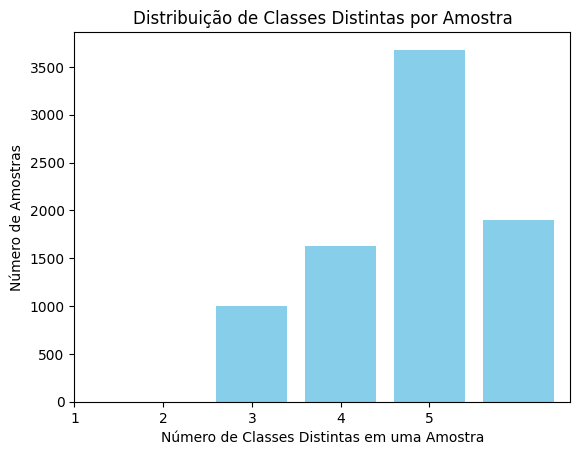

Distribuição Geral de Classes nos Batches:
Classe 0: 152539934 (28.58%)
Classe 1: 63298125 (11.86%)
Classe 2: 256080518 (47.98%)
Classe 3: 37366294 (7.00%)
Classe 4: 17795842 (3.33%)
Classe 5: 6644487 (1.24%)


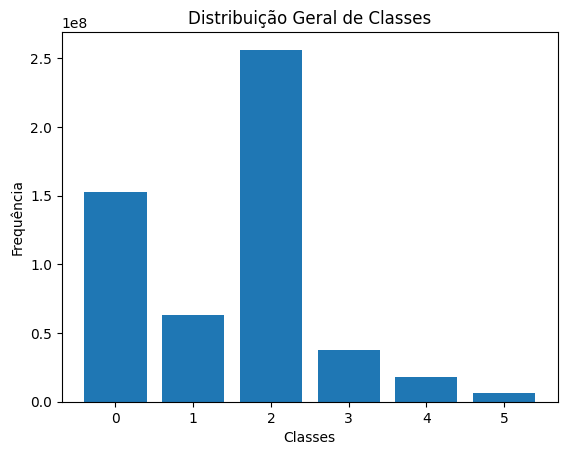

Distribuição balanceada dentro do limiar definido.


In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def analyze_classes_per_batch(dataloader):
    batch_class_distribution = []  # Armazena a quantidade de classes por amostra em cada batch

    print("Total de batches: ", len(dataloader))
    for batch in dataloader:
        images, labels = batch  # Assuma que os batches retornam (imagens, rótulos)
        # print(images.shape, labels.shape)
        # print(images[0].shape, labels[0].shape)
        contagem = []
        for label in labels:
            # Encontrar classes únicas na amostra
            unique_classes = np.unique(label)
            contagem.append(len(unique_classes))
        batch_class_distribution.append(contagem)

    print("Distribuição por batch:", len(batch_class_distribution), batch_class_distribution)

    # Achatar a lista para considerar todas as amostras
    flattened_distribution = [item for sublist in batch_class_distribution for item in sublist]

    # Contar as ocorrências de cada número de classes em uma amostra
    sample_class_count = Counter(flattened_distribution)

    # Exibir resultados
    print("\nDistribuição de Quantidades de Classes por Amostra:")
    for num_classes, count in sorted(sample_class_count.items()):
        print(f"{num_classes} classes presentes em {count} amostras")

    # Visualizar em gráfico
    plt.bar(sample_class_count.keys(), sample_class_count.values(), color='skyblue')
    plt.xlabel("Número de Classes Distintas em uma Amostra")
    plt.ylabel("Número de Amostras")
    plt.title("Distribuição de Classes Distintas por Amostra")
    plt.xticks(range(1, 6))  # Ajustar para o número esperado de classes
    plt.show()

    return sample_class_count

class_count_distribution = analyze_classes_per_batch(train_loader)

def analyze_class_distribution_efficient(dataloader):
    """Analisa a distribuição de classes de forma eficiente em termos de memória."""
    class_counts = Counter()

    for batch in dataloader:
        _, labels = batch  # Assuma que o batch retorna (imagens, rótulos)
        
        # Atualiza os contadores com os rótulos do batch
        for label_patch in labels:
            unique, counts = np.unique(label_patch.numpy(), return_counts=True)
            class_counts.update(dict(zip(unique, counts)))

    # Total de amostras
    total_samples = sum(class_counts.values())

    # Exibir distribuição
    print("Distribuição Geral de Classes nos Batches:")
    for cls, count in sorted(class_counts.items()):
        print(f"Classe {cls}: {count} ({count / total_samples:.2%})")

    # Visualizar como gráfico
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Classes")
    plt.ylabel("Frequência")
    plt.title("Distribuição Geral de Classes")
    plt.show()

    return class_counts

# Verificar distribuição nos batches do conjunto de treino
class_counts = analyze_class_distribution_efficient(train_loader)

# Opcional: Verificar desbalanceamento
def check_global_imbalance(class_counts, threshold=0.5):
    total_samples = sum(class_counts.values())
    max_percentage = max(count / total_samples for count in class_counts.values())
    if max_percentage > threshold:
        print(f"ALERTA: A classe dominante representa mais de {threshold * 100:.0f}% dos dados!")
    else:
        print("Distribuição balanceada dentro do limiar definido.")

check_global_imbalance(class_counts, threshold=0.5)

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


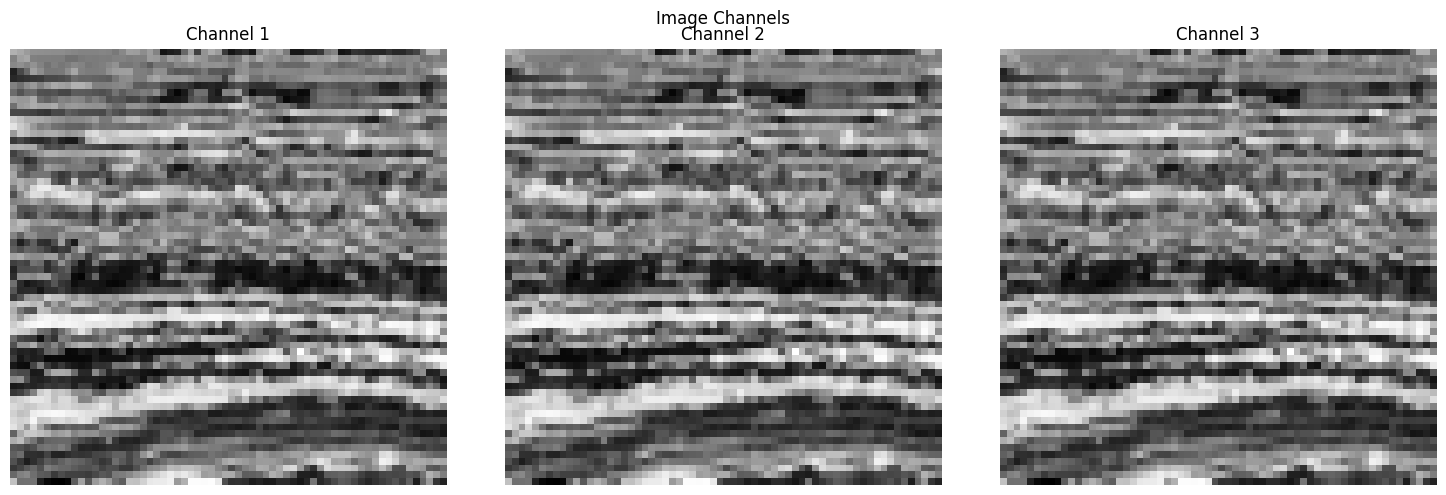

[0.         0.00392157 0.00784314 0.01176471]


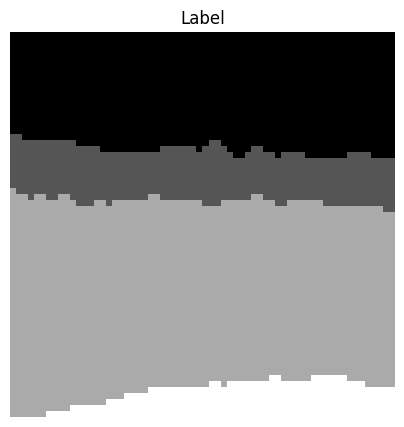

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


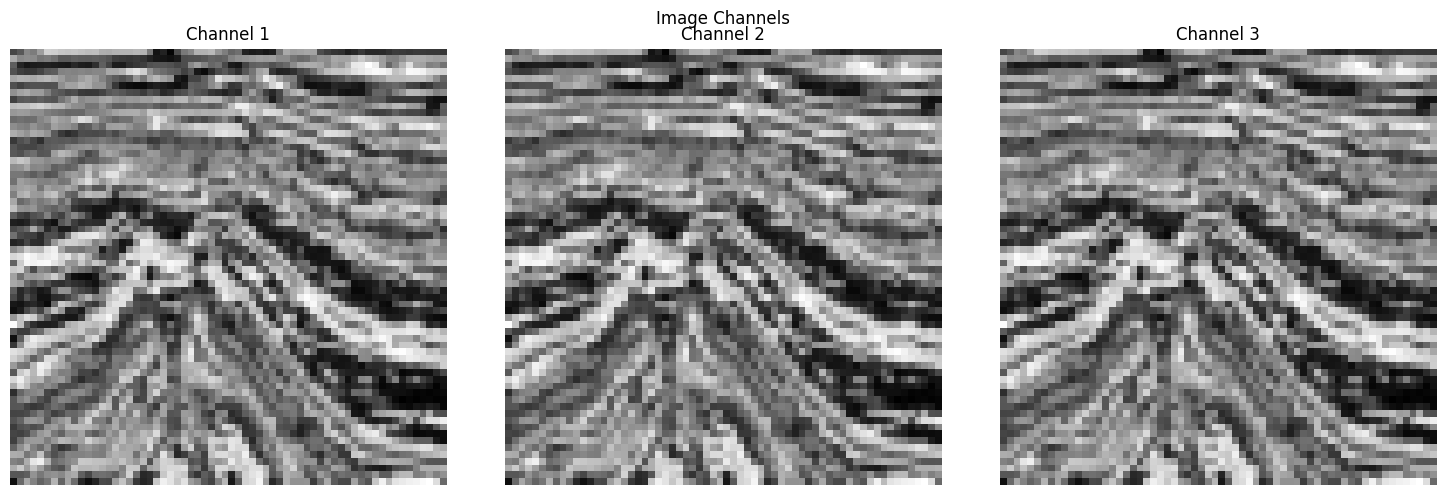

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784]


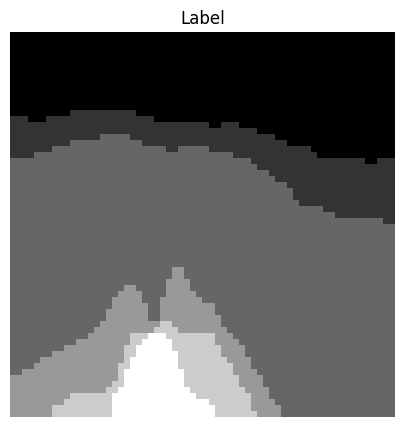

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


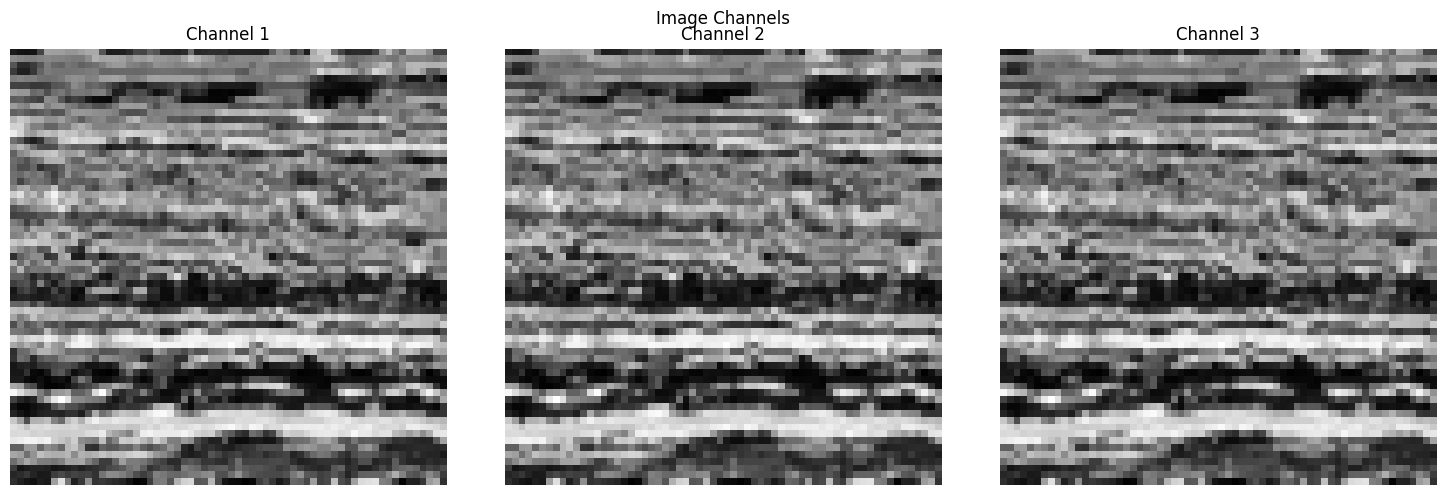

[0.         0.00392157 0.00784314 0.01176471]


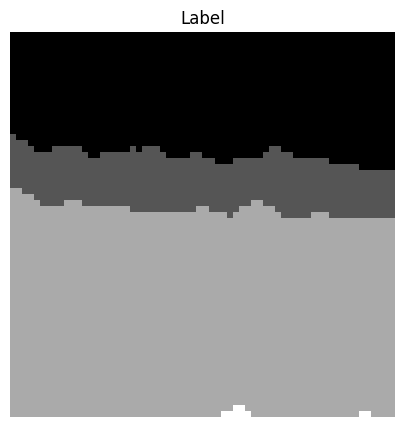

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


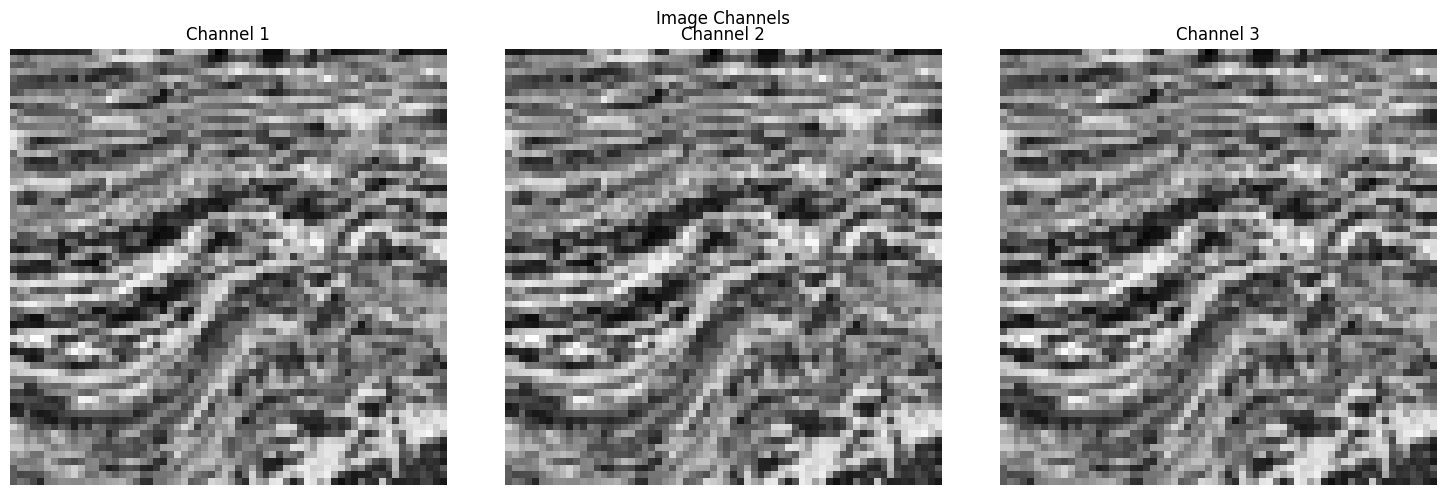

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784]


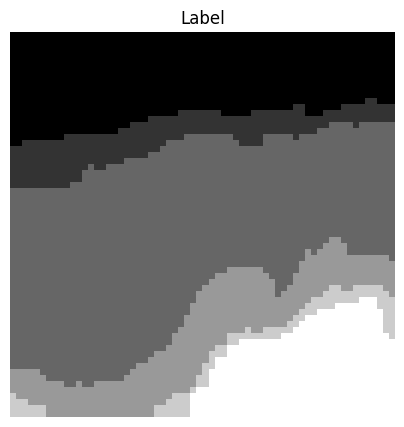

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


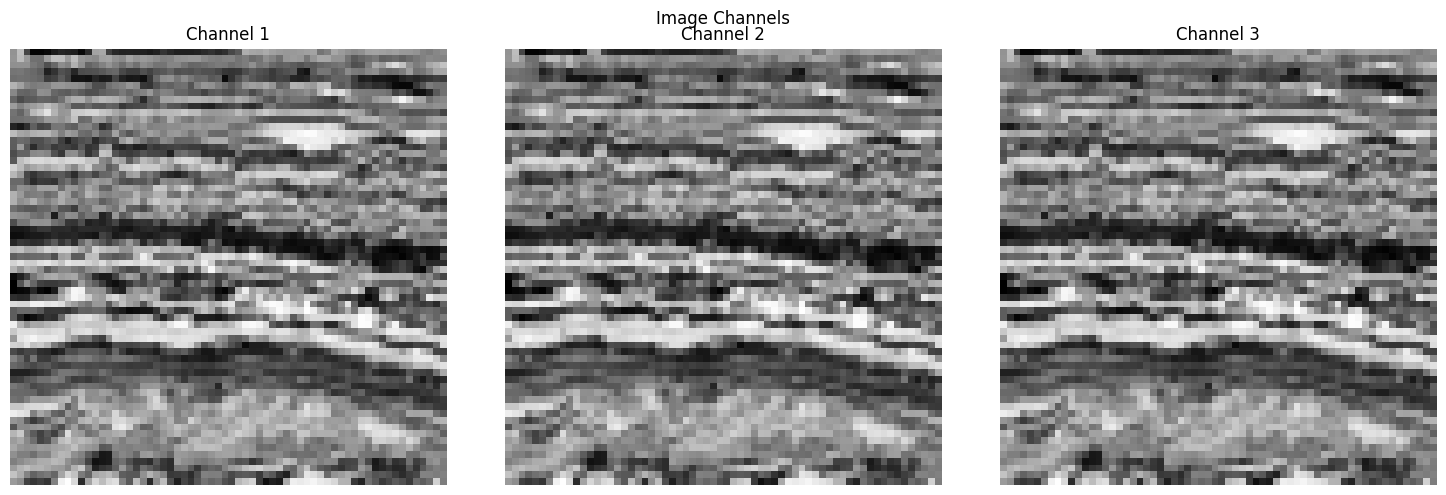

[0.         0.00392157 0.00784314 0.01176471 0.01568628]


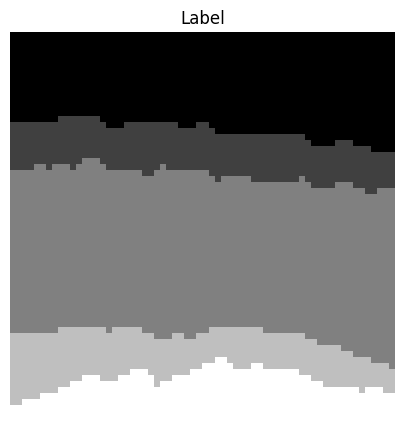

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


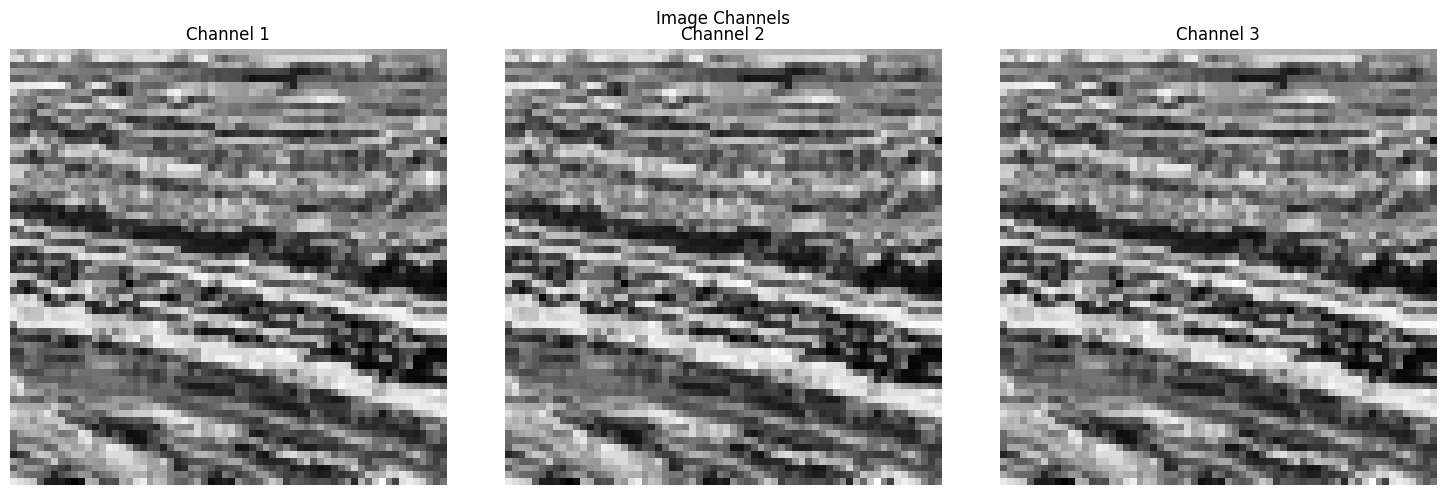

[0.         0.00392157 0.00784314 0.01176471 0.01568628]


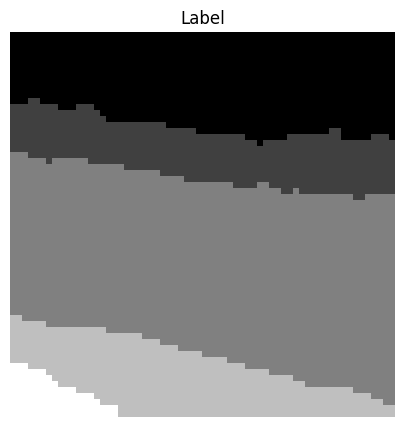

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


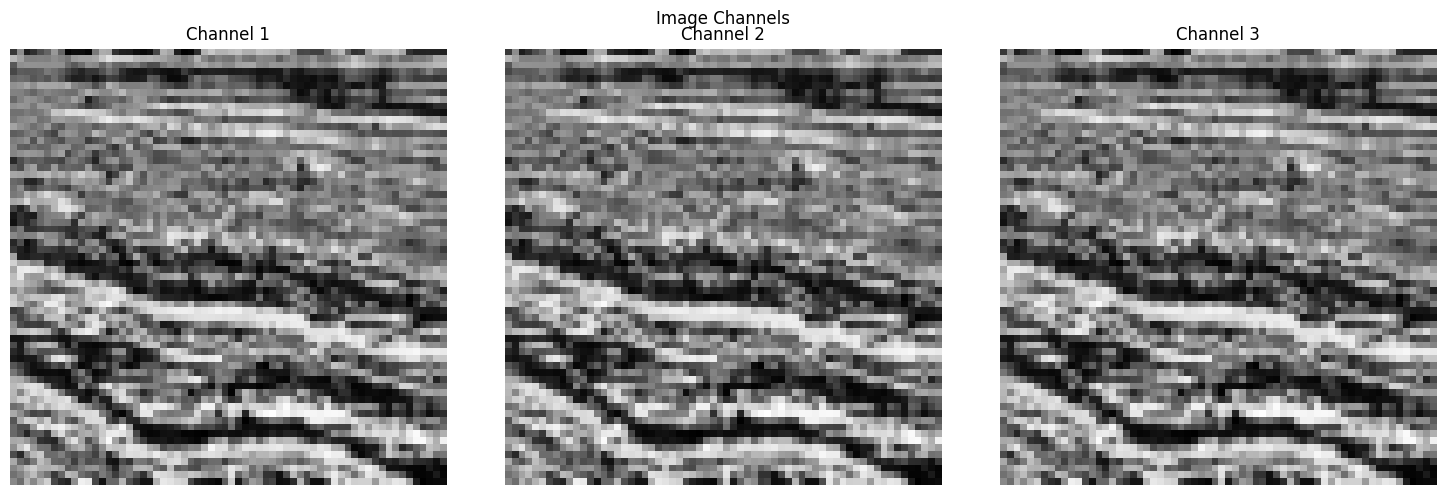

[0.         0.00392157 0.00784314]


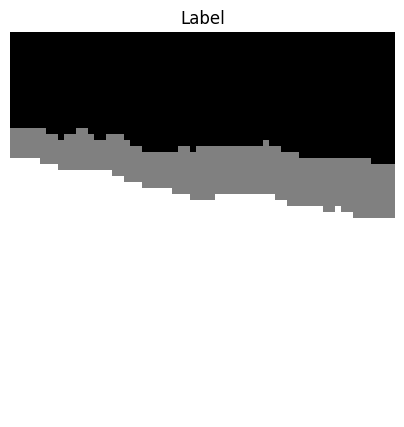

torch.Size([3, 64, 64]) torch.Size([1, 64, 64])


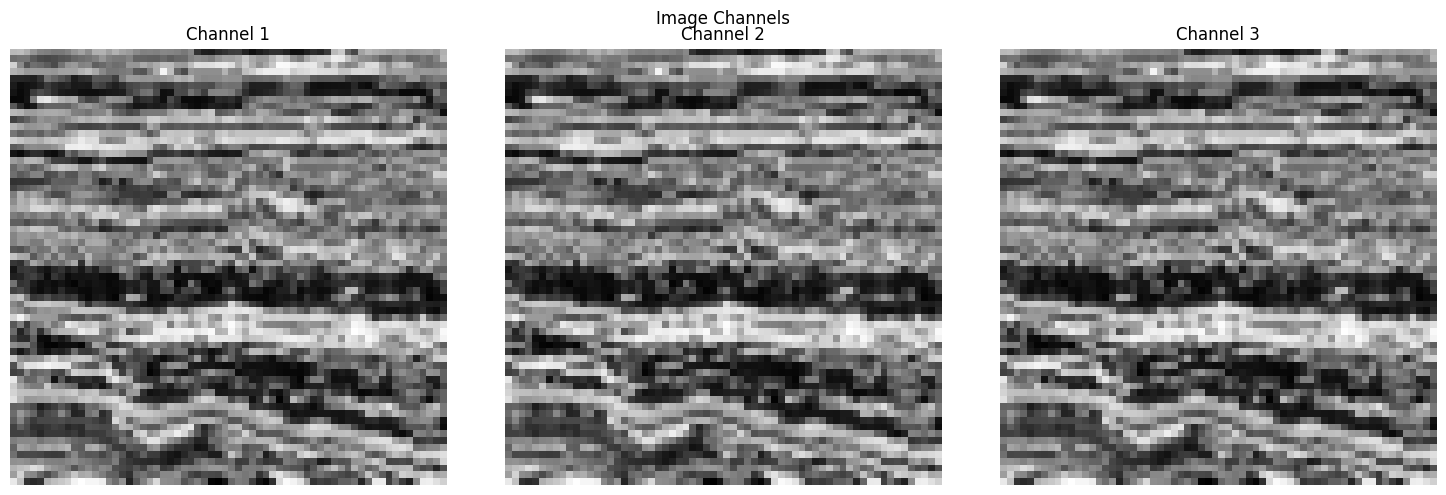

[0.         0.00392157 0.00784314 0.01176471]


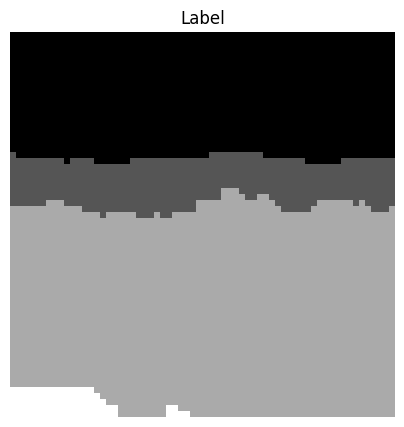

In [ ]:
for batch in train_loader:
    images, labels = batch  # Assuma que os batches retornam (imagens, rótulos)
    
    # Exiba algumas imagens do batch
    for i in range(len(images)):
        plot_image_channels(images[i])
        print(np.unique(labels[i]))
        plot_image_labels(labels[i])

    # Saia do loop após o primeiro batch
    break

In [9]:
data_module.setup(stage='test')
test_loader = data_module.train_dataloader()

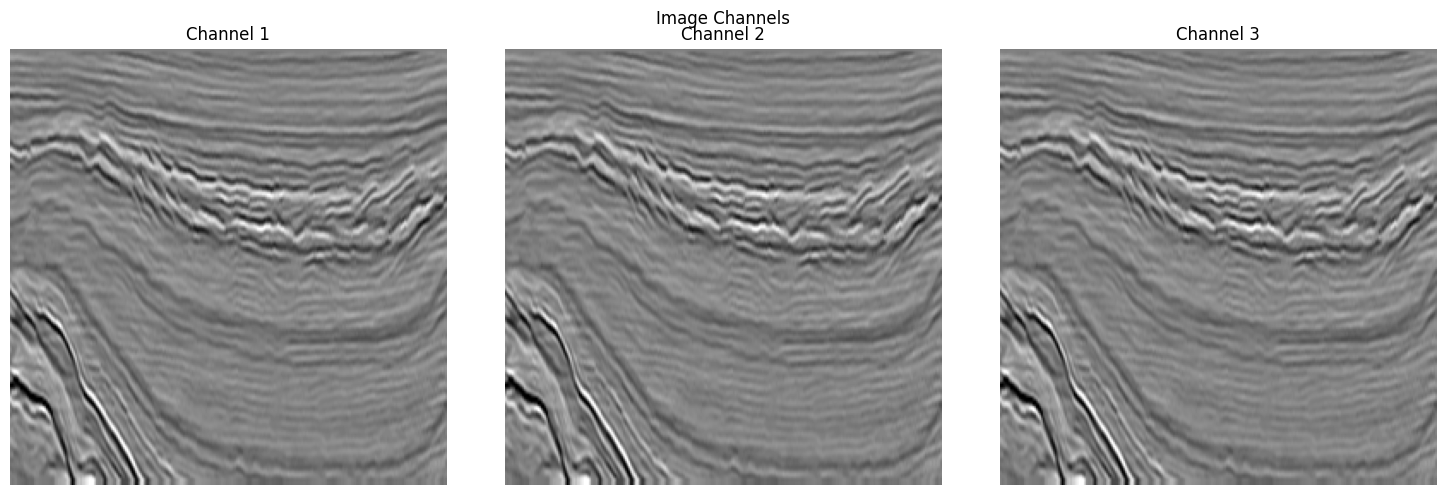

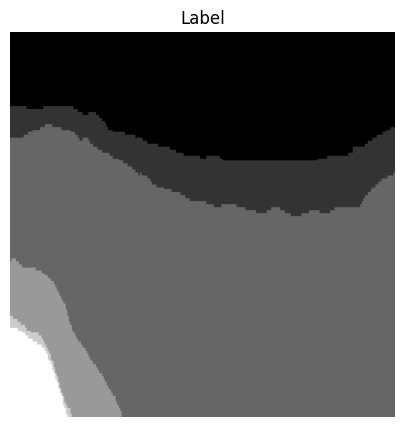

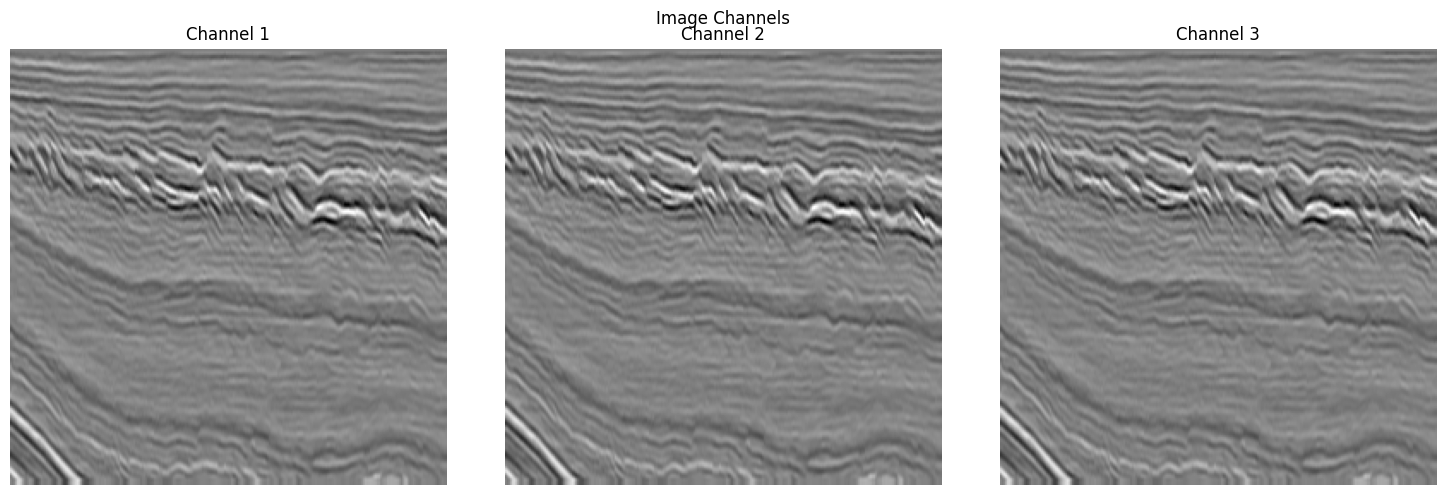

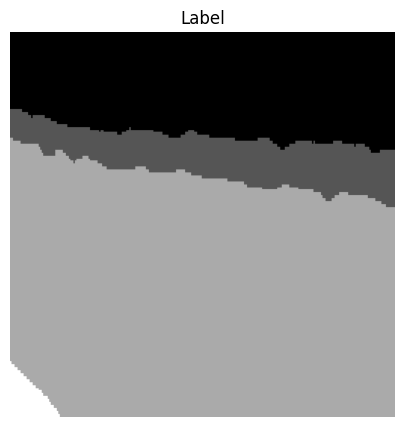

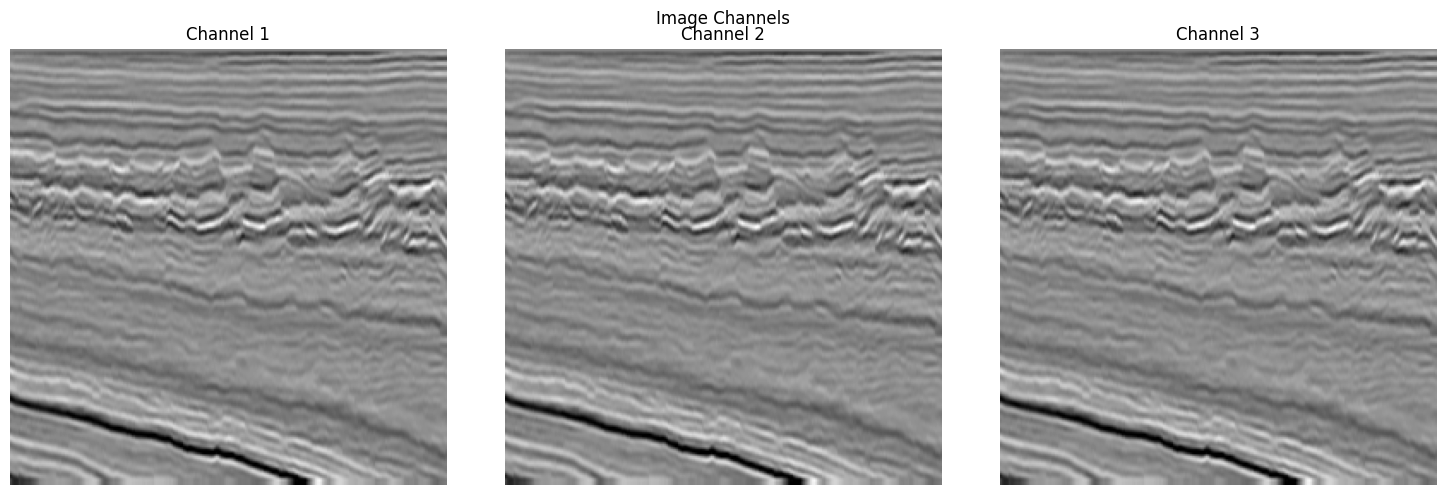

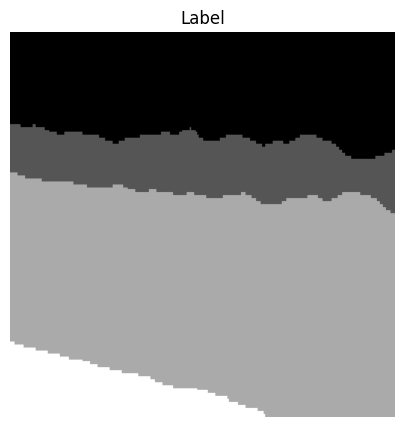

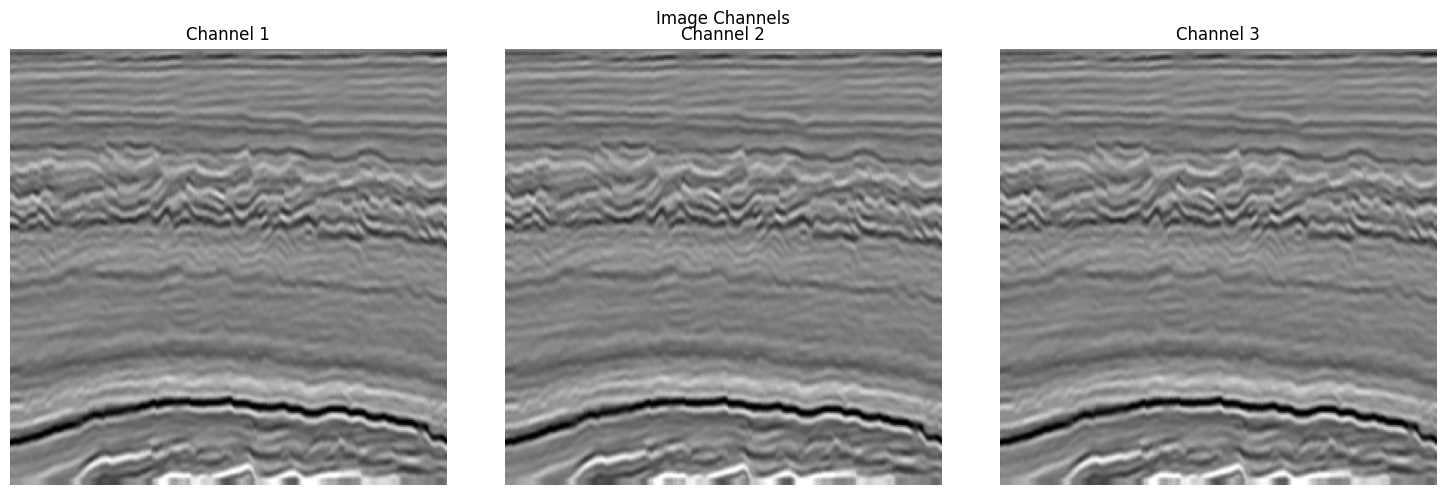

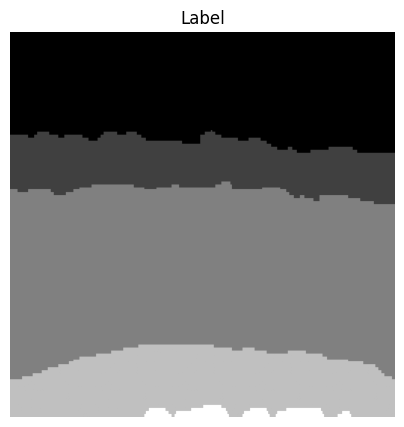

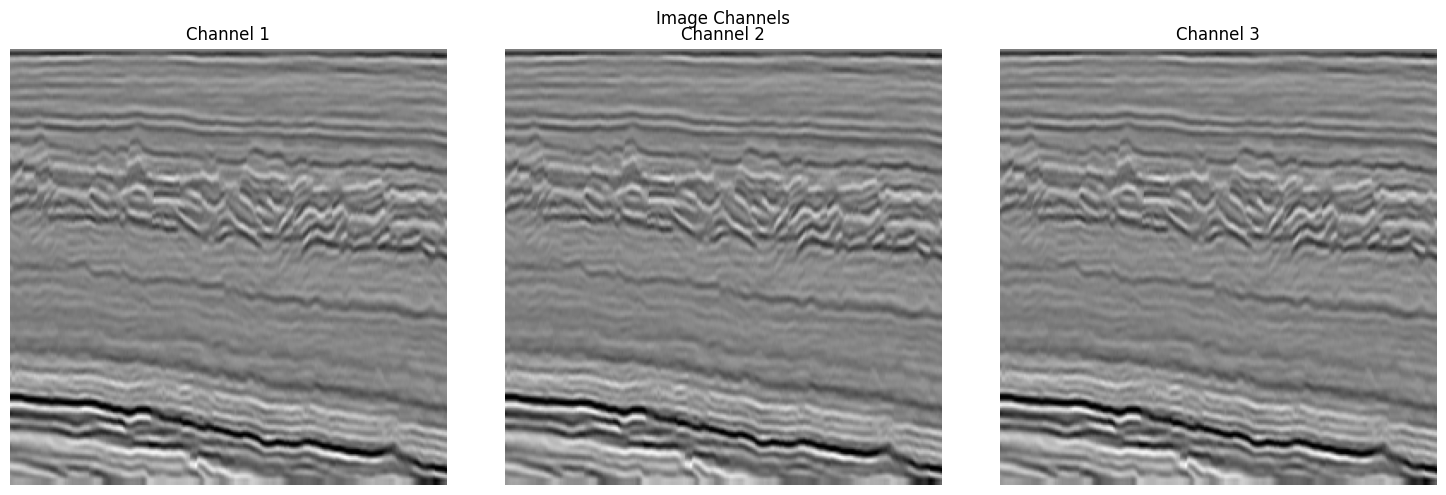

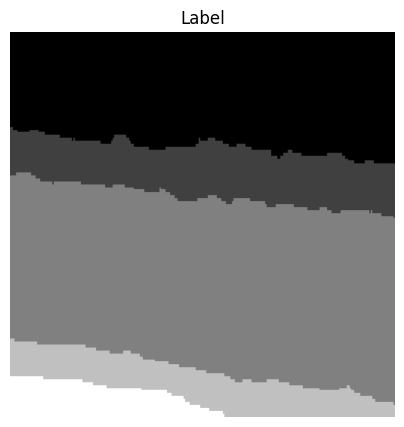

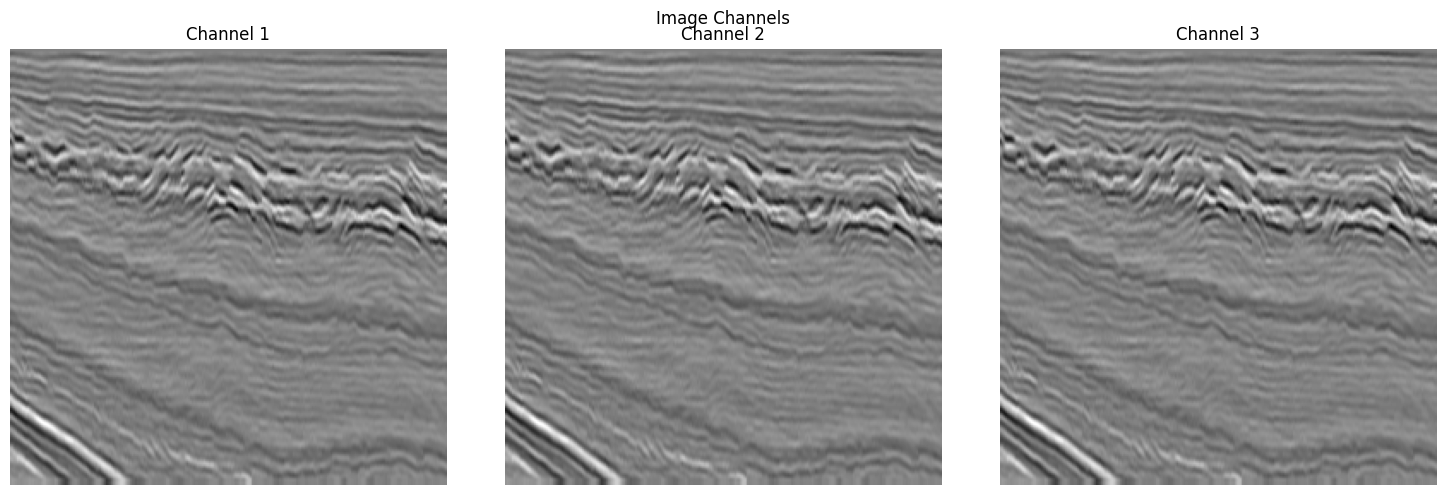

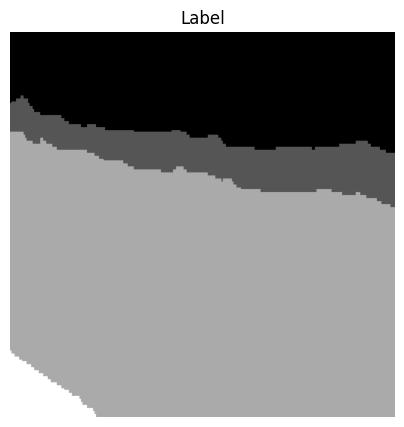

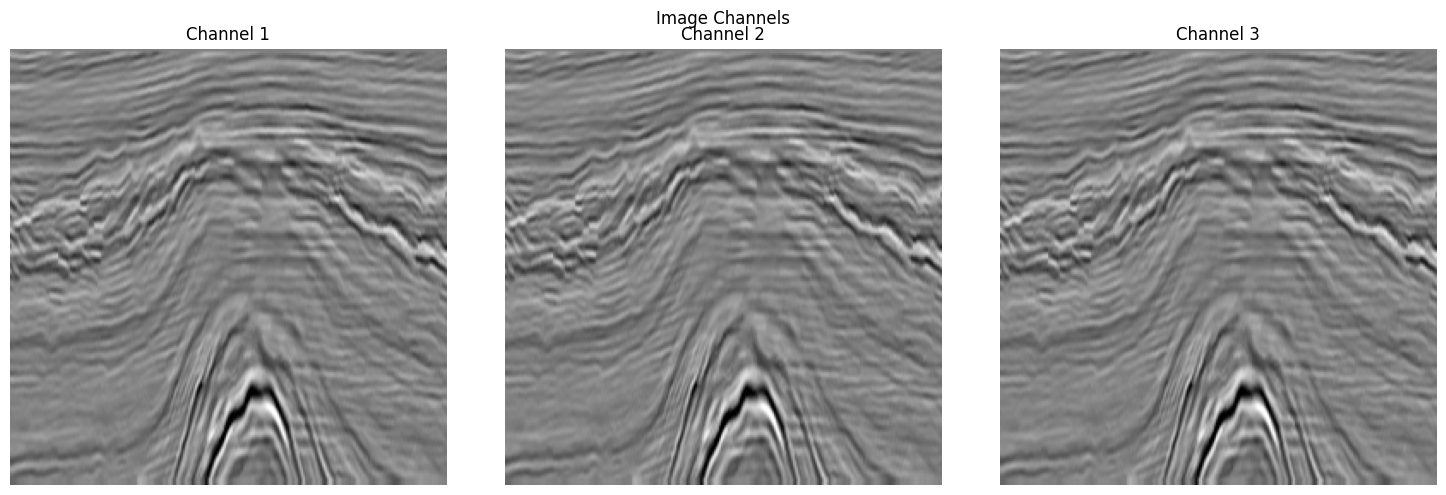

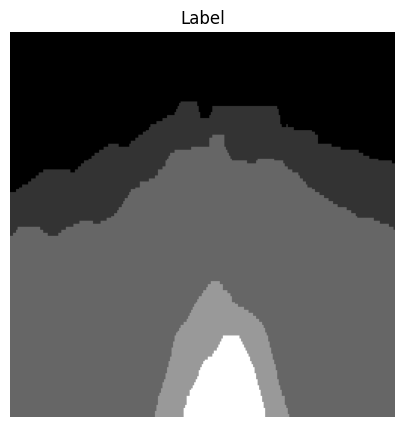

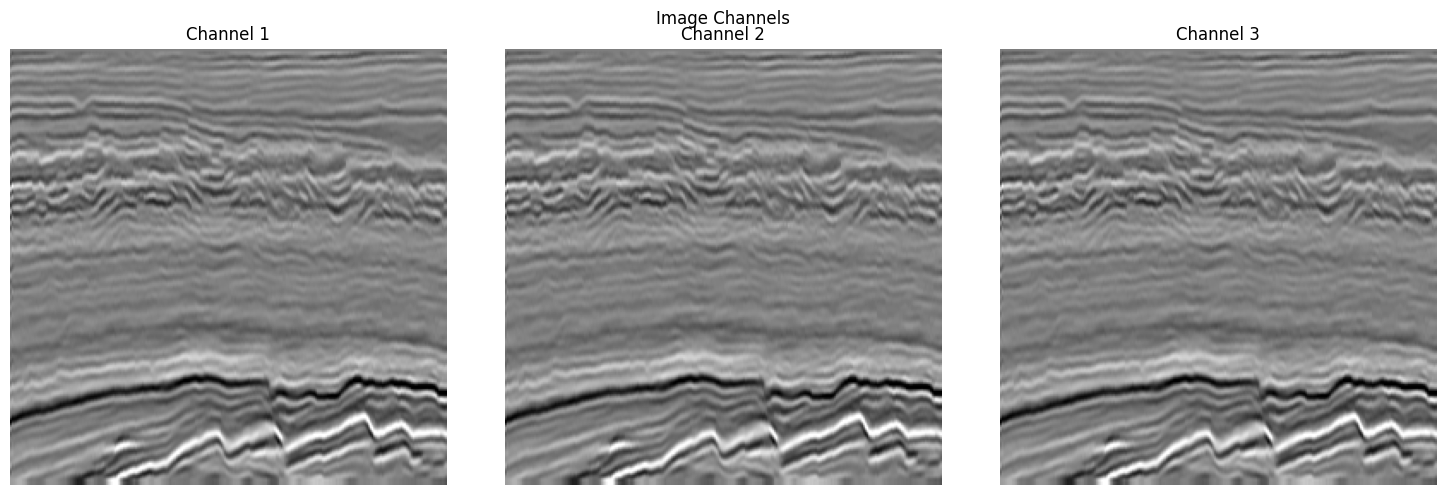

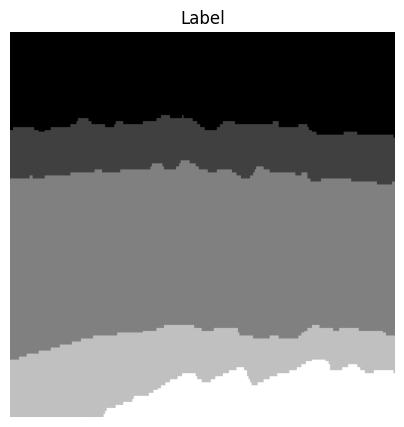

In [10]:
for batch in test_loader:
    images, labels = batch  # Assuma que os batches retornam (imagens, rótulos)
    
    # Exiba algumas imagens do batch
    for i in range(len(images)):
        plot_image_channels(images[i])
        plot_image_labels(labels[i])

    # Saia do loop após o primeiro batch
    break